In [1]:
import time
import numpy as np
import cooltools.lib.plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

from time import time
from k_medoids import KMedoids
from cluster_statistics import ClusterStatistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from data_preparation import DataPreparation
from dissimilarity_matrix import DissimilarityMatrix


In [2]:
# get path to multi resolution hic data
path_wt = '/home/elinfi/coolers/HiC_wt_001.mcool'
path_cancer = '/home/elinfi/coolers/HiC_cancer_001.mcool'

resolution = 32000
region = 'chr4:5M-7M' # region of genome
balance = True

# create objects of class
wt = DataPreparation(path_wt, resolution, region, balance)
cancer = DataPreparation(path_cancer, resolution, region, balance)


# divide matrices
#diff_mat = wt.divide(cancer, replace_zero_zero=False)
diff_mat = cancer.subtract(wt)
print(wt.matrix.shape)

(63, 63)


In [3]:
# globally set font sizes
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

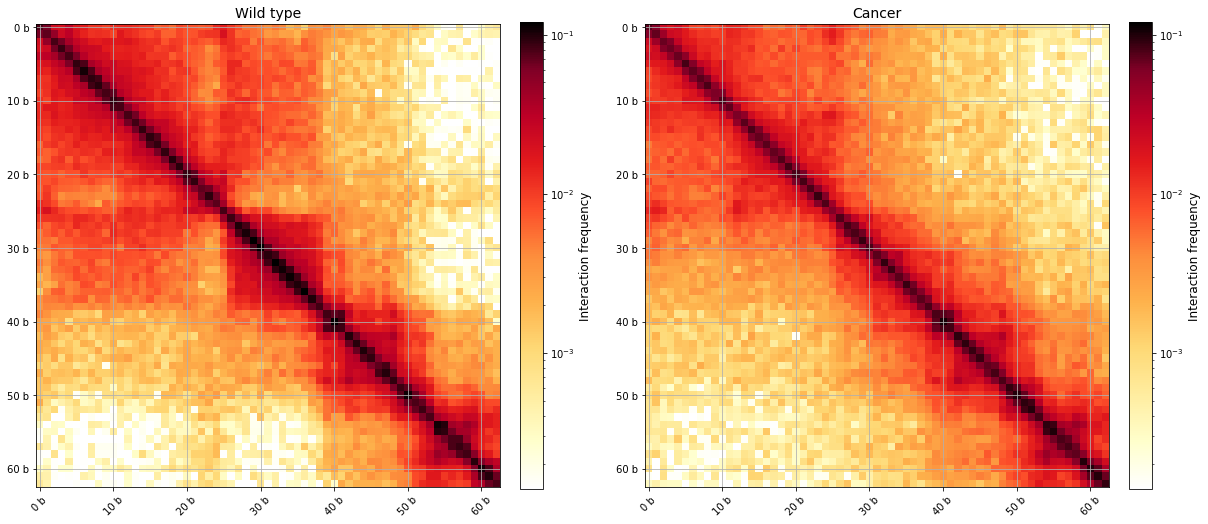

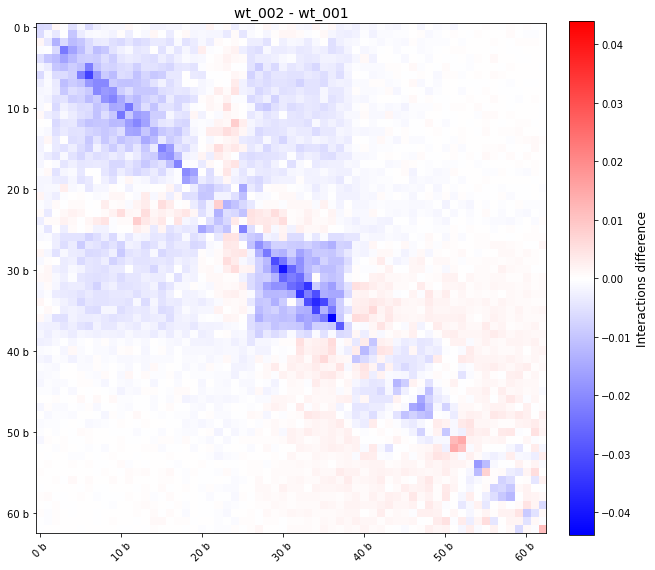

In [5]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=2,
                      sharex=True, sharey=False)

norm = mpl.colors.LogNorm()
#norm = None

ax = axs[0]
im = ax.matshow(wt.matrix,
                norm=norm,
                cmap='fall',
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interaction frequency', ax=ax)
ax.grid(b=True)
ax.set(title='Wild type')
format_ticks(ax)

ax = axs[1]
im = ax.matshow(cancer.matrix,
                norm=norm,
                cmap='fall',
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interaction frequency', ax=ax)
ax.grid(b=True)
ax.set(title='Cancer')
format_ticks(ax)

f, axs = plt.subplots(figsize=(10, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)
ax = axs
vmax = np.nanmax(abs(diff_mat))
im = ax.matshow(diff_mat,
                vmax=vmax,
                vmin=-vmax,
                cmap='bwr')
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set(title='wt_002 - wt_001')
plt.savefig('../Figures/sub_002_001.png')
format_ticks(ax)

In [6]:
### create distance matrix
dissimilarity = DissimilarityMatrix(diff_mat, scaler=None)

# interactions difference
start = time()
interactions_dist = dissimilarity.scipy_dist(metric='interactions_dist', col1=0, col2=3)
end = time()
print(f'Time interactions_dist: {end - start}')

# diagonal distance
start = time()
diagonal_dist = dissimilarity.scipy_dist(metric='diagonal_dist', col1=0, col2=3)
end = time()
print(f'Time diagonal_dist: {end - start}')
"""
# manhattan distance
start = time()
manhattan_dist = dissimilarity.scipy_dist(metric='manhattan')
end = time()
print(f'Time manhattan_dist: {end - start}')
"""
# manhattan distance
start = time()
euclidean_dist = dissimilarity.scipy_dist(metric='minkowski', col1=0, col2=2, p=1)/(2*dissimilarity.n)
end = time()
print(f'Time manhattan_dist: {end - start}')

# manhattan distance
start = time()
euclidean_dist = dissimilarity.scipy_dist(metric='diag_3d_dist', col1=0, col2=3)
end = time()
print(f'Time manhattan_dist: {end - start}')

Time interactions_dist: 4.064535856246948


/home/elinfi/MasterCode/clustering/dissimilarity_matrix.py:156: RuntimeWarning: divide by zero encountered in log
  d1 = np.log(abs(u[0] - u[1])/self.n)
/home/elinfi/MasterCode/clustering/dissimilarity_matrix.py:157: RuntimeWarning: divide by zero encountered in log
  d2 = np.log(abs(v[0] - v[1])/self.n)
/home/elinfi/MasterCode/clustering/dissimilarity_matrix.py:159: RuntimeWarning: invalid value encountered in double_scalars
  dist = abs(d1 - d2)


Time diagonal_dist: 21.091882467269897
Time manhattan_dist: 0.10146713256835938
Time manhattan_dist: 26.84481143951416


In [7]:
# calculate weighted distance matrix
w1 = 0
w2 = 1
w3 = 0
w4 = 0

#dist_mat = w1*interactions_dist + w2*diagonal_dist + w3*manhattan_dist + w4*euclidean_dist
dist_mat = w1*interactions_dist + w2*diagonal_dist

In [18]:
### calculate kmedoids clusters
medoids = 2
random_state = 19

n = dissimilarity.n
triu_nan_idx = dissimilarity.triu_nan_idx

# find clusters using k-medoids
kmedoids = KMedoids(dist_mat)
cluster_result = kmedoids.clusters(medoids=medoids, random_state=random_state)
labels_mat = kmedoids.labels4plotting_nan(n, triu_nan_idx)


In [19]:
# create discrete colormap
cmap = plt.cm.cool
bounds = np.linspace(0, medoids, medoids+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

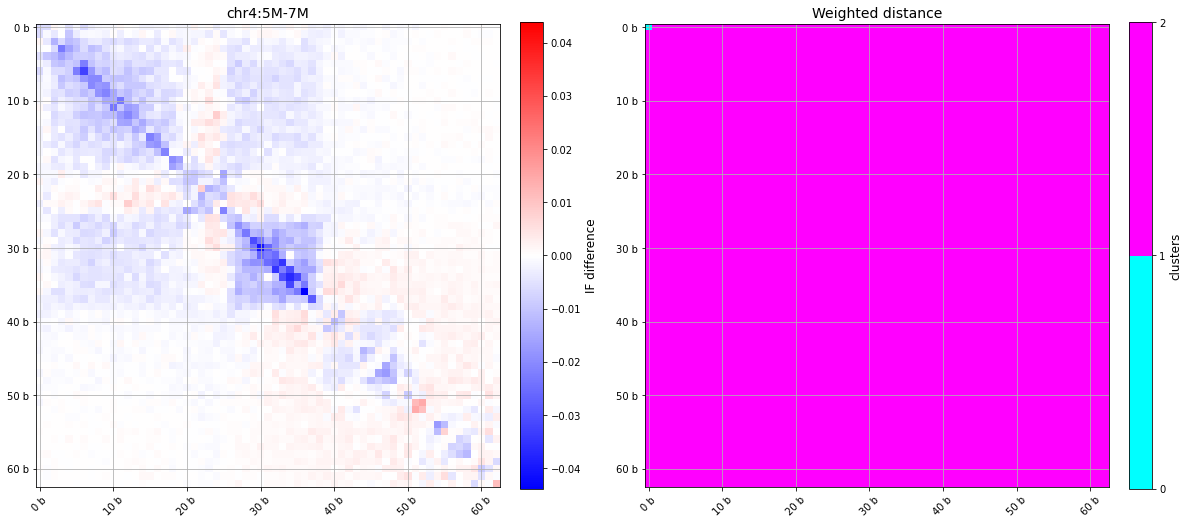

In [20]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=2,
                      sharex=True, sharey=False)

ax = axs[0]
vmax = np.nanmax(abs(diff_mat))
im = ax.matshow(diff_mat,
                vmax=vmax,
                vmin=-vmax,
                cmap='bwr')
plt.colorbar(im, fraction=0.046, pad=0.04, label='IF difference', ax=ax)
ax.grid(b=True)
ax.set(title=region)
format_ticks(ax)

ax = axs[1]
im = ax.matshow(labels_mat,
                norm=norm,
                cmap=cmap,
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='clusters', ax=ax)
ax.grid(b=True)
ax.set(title='Weighted distance')
plt.savefig(f"../Figures/w1_{w1:.2f}_interactions_w2_{w2:.2f}_diag.png")
format_ticks(ax)

/home/elinfi/.venvs/hic/lib64/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.


IndexError: index 2 is out of bounds for axis 0 with size 2

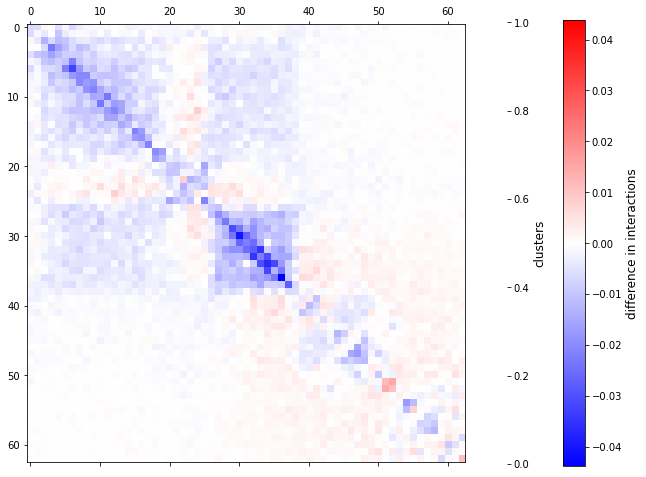

In [21]:
f, axs = plt.subplots(figsize=(10, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)

ax = axs
vmax = np.nanmax(abs(diff_mat))
im = ax.matshow(diff_mat,
                #norm=mpl.colors.LogNorm(),
                cmap='bwr',
                vmin=-vmax,
                vmax=vmax)
plt.colorbar(im, fraction=0.04, pad=0.1, label='difference in interactions', ax=ax)

im = ax.contour(labels_mat,
                norm=norm,
                cmap='cool',
                levels=bounds,
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='clusters', ax=ax)
ax.set(title=region)
ax.set_facecolor('xkcd:green')

In [ ]:
stats = ClusterStatistics(medoids, cluster_result.labels, dissimilarity.X)
mean_list = stats.cluster_mean('diagonal_dist')
print(mean_list)